## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

In [ ]:
preds, ground_truth, loss_avg = evaluate_rnn(
    model, criterion, optimizer, dev_loader, device)

In [19]:
import json
import matplotlib.pyplot as plt
import random
import sys
from collections import defaultdict
from pathlib import Path
from time import sleep, time

import IPython
import matplotlib.pyplot as pltf
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import Dataset, DatasetPyTorch, collate_fn
from evaulate import eval_perf_binary, evaluate_rnn
from glove import Glove
from models import RNNModel
from pytorchtools import EarlyStopping

# nltk.download('stopwords')

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"CUDA enabled device: {device}")

True
CUDA enabled device: cuda:1


In [3]:
_time_start = time()
glove_path = Path('/home/ianic/tar/Bot-Detection/glove/glove.twitter.27B.50d.txt')
bert_path_train = Path('/home/ianic/tar/Bot-Detection/bert_embeddings_train.json')
bert_path_test = Path('/home/ianic/tar/Bot-Detection/bert_embeddings_test.json')

print(glove_path.exists())
_df_train = pd.read_pickle("../../pan19_df_clean_train_glove.pkl")
_df_test = pd.read_pickle("../../pan19_df_clean_test_glove.pkl")

print(_df_test['bot'].value_counts(normalize=True) * 100)

True
human    50.0
bot      50.0
Name: bot, dtype: float64


In [4]:
n_dev = 82400 # 20%
_df_train.shape[0]

412000

In [5]:
df_train = _df_train.head(-n_dev)
df_dev = _df_train.tail(n_dev) 
df_test = _df_test

In [6]:
print(df_train.info())
print(df_dev.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329600 entries, 0 to 329599
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   author       329600 non-null  object
 1   tweet        329600 non-null  object
 2   bot          329600 non-null  object
 3   clean_tweet  329600 non-null  object
dtypes: object(4)
memory usage: 10.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82400 entries, 329600 to 411999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       82400 non-null  object
 1   tweet        82400 non-null  object
 2   bot          82400 non-null  object
 3   clean_tweet  82400 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264000 entries, 0 to 263999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   

In [7]:
df_dev.reset_index(inplace=True)
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82400 entries, 0 to 82399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        82400 non-null  int64 
 1   author       82400 non-null  object
 2   tweet        82400 non-null  object
 3   bot          82400 non-null  object
 4   clean_tweet  82400 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.1+ MB


### Subset

In [8]:
df_train = df_train.head(41200)
df_dev = df_dev.head(13200)
df_test = df_test.head(13200)

In [9]:
lr = 1e-4
num_epoch = 20
batch_size_train = 64
batch_size_test = 32
gradient_clip = 0.25
torch.manual_seed(7052020)
np.random.seed(7052020)

In [10]:
_time = time()

embedding_source = 'bert'
print(f"loading data: {time() - _time}")

loading data: 8.082389831542969e-05


In [11]:
bert_dict_train = None
with open(Path(bert_path_train), 'r') as f:
    bert_dict_train = json.load(f)
print("Initialized train embeddings!")

Initialized train embeddings!


In [12]:
train_dataset = DatasetPyTorch(
    dataset=df_train, embeddings=bert_dict_train,
    embedding_source=embedding_source)
dev_dataset = DatasetPyTorch(
    dataset=df_dev, embeddings=bert_dict_train,
    embedding_source=embedding_source)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train,
    shuffle=True, num_workers=32,
    drop_last=True, pin_memory=False)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size_train,
    shuffle=True, num_workers=32,
    drop_last=True, pin_memory=False)

print(f"loading data: {time() - _time}")

loading data: 142.84514117240906


In [14]:
model = RNNModel(
    cell_type='lstm', embedding_size=DatasetPyTorch.embedding_size,
    num_layers=2, bidirectional=False, dropout_prob=0)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)
print("training")
model = model.to(device)

training


In [15]:
def train_model(model, batch_size, patience, n_epochs):
    train_losses = []
    avg_train_losses = []
    avg_dev_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(num_epoch):
        _time = time()
        model.train()
        for batch, (data, target) in enumerate(train_loader):
            data = data.to(device, non_blocking=True)
            labels = target.to(device, non_blocking=True)

            data = torch.transpose(data, 0, 1)  # time-first format, speed gain
            labels = labels.squeeze()
            logits = model(data)

            loss = criterion(logits, labels)
            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()

            train_losses.append(loss.item())

        print(f"epoch time: {time() - _time}")
        _time = time()
        preds, ground_truth, loss_avg = evaluate_rnn(
            model, criterion, optimizer, dev_loader, device)

        train_loss = np.mean(train_losses)
        dev_loss = np.mean(loss_avg)
        avg_train_losses.append(train_loss)
        avg_dev_losses.append(dev_loss)
        train_losses = []

        accuracy, recall, precision, f1 = eval_perf_binary(preds, ground_truth)
        print(f"epoch: {epoch}, inference time:{time() - _time},",
              f"train_loss_avg: {train_loss}, dev_loss_avg: {dev_loss}",
              f"acc: {accuracy}, recall: {recall}, precision: {precision}, f1: {f1}")

        early_stopping(dev_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_dev_losses

In [16]:
n_epochs = 100
patience = 20

model, train_loss, valid_loss = train_model(
    model, batch_size_train, patience, n_epochs)

epoch time: 14.220276355743408
epoch: 0, inference time:9.022884368896484, train_loss_avg: 0.455020797869095, dev_loss_avg: 0.45068726384813346 acc: 0.802563713592233, recall: 0.8169981399341822, precision: 0.8117713960762013, f1: 0.8143763816587035
Validation loss decreased (inf --> 0.450687).  Saving model ...
epoch time: 14.197968244552612
epoch: 1, inference time:8.566611528396606, train_loss_avg: 0.3428652191282616, dev_loss_avg: 0.42455472536746736 acc: 0.818871359223301, recall: 0.7900157345158061, precision: 0.8572093745149775, f1: 0.8222420723537294
Validation loss decreased (0.450687 --> 0.424555).  Saving model ...
epoch time: 14.977852821350098
epoch: 2, inference time:8.862171649932861, train_loss_avg: 0.30939017567627164, dev_loss_avg: 0.4176346638682977 acc: 0.8266080097087378, recall: 0.7947654462242563, precision: 0.8671972534332085, f1: 0.829402985074627
Validation loss decreased (0.424555 --> 0.417635).  Saving model ...
epoch time: 14.327699899673462
epoch: 3, infer

In [30]:
bert_dict_test = None
with open(Path(bert_path_test), 'r') as f:
    bert_dict_test = json.load(f)
print("Initialized test embeddings!")

test_dataset = DatasetPyTorch(
    dataset=df_test, embeddings=bert_dict_test,
    embedding_source=embedding_source)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size_test,
    shuffle=True, num_workers=100,
    drop_last=False, pin_memory=True)

preds, ground_truth, loss_avg = evaluate_rnn(
    model, criterion, optimizer, test_loader, device)
accuracy, recall, precision, f1 = eval_perf_binary(preds, ground_truth)

print(f"epochs: {num_epoch}, total execution time:{time() - _time_start}, "
      f"loss_avg: {np.mean(loss_avg)}, acc: {accuracy}, "
      f"recall: {recall}, precision: {precision}, f1: {f1}")

epochs: 5, total execution time:3875.949556827545, loss_avg: 0.48512923006716996, acc: 0.7913636363636364, recall: 0.7139705882352941, precision: 0.8571680790960452, f1: 0.7790436456996148


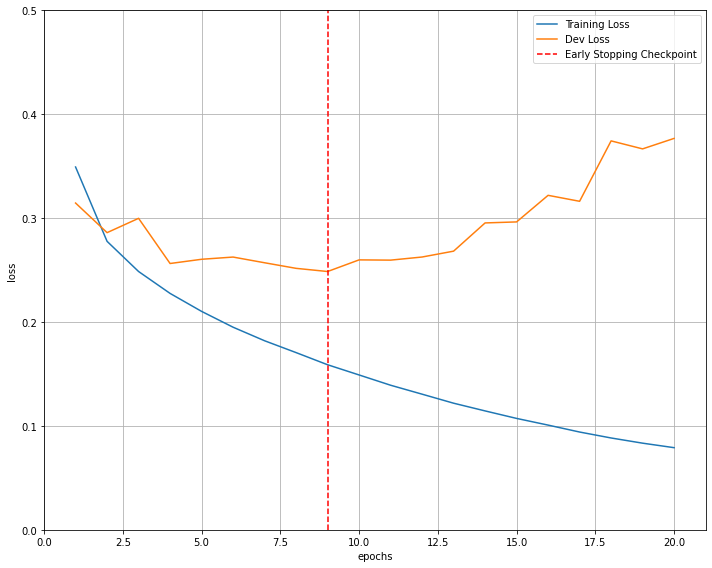

In [28]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
plt.plot(range(1, len(valid_loss)+1), valid_loss, label='Dev Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',
            label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)
plt.xlim(0, len(valid_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')